In [133]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn

from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats

#### 1. Import boundaries and population raster

In [135]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,32.668022,0.408476,0.21705,32.509629,"POLYGON ((32.5096294 0.3100581, 32.5097488 0.3...","Kampala, Central Region, Uganda"


In [136]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')

In [137]:
points_ED = gpd.read_file("data/jobdensity_kampala_points.shp")
ED_clipped = gpd.sjoin(points_ED,boundary_GDF,how='inner')

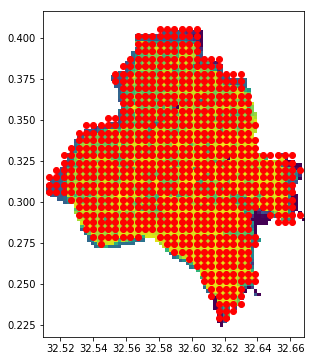

In [138]:
f,ax = plt.subplots(figsize=[6,6])
show(pop_raster, ax=ax)
ED_clipped.plot(ax = ax, color='r')

#### 2. Get POIs

In [139]:
bbox = pop_raster.bounds

amenities = ['hospital','clinic']
POIs = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities)))

In [140]:
POIs.amenity.value_counts()

clinic      283
hospital     58
Name: amenity, dtype: int64

In [141]:
POIs = POIs[['amenity','name','lat','lon']]
POIs.head()

,amenity,name,lat,lon
id,,,,
294016124,hospital,Rubaga Hospital,0.303553,32.552608
294017966,hospital,St. Francis Hospital Nsambya,0.300852,32.587018
294018724,hospital,Hope Clinic Lukuli,0.279922,32.600445
582857059,hospital,Kololo Hospital Kampala Ltd.,0.333829,32.589159
583203221,hospital,Kibuli Muslim Hospital,0.309318,32.595147


In [198]:
POIs = gpd.read_file('data/POIs_shp')

In [199]:
POIs = gpd.GeoDataFrame(POIs)
POIs['geometry'] = (list(zip(POIs.lon,POIs.lat)))
POIs['geometry'] = POIs.geometry.apply(lambda x: Point(x))

POIs = gpd.sjoin(POIs,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [143]:
POIs.to_file('data/POIs_shp')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [144]:
raster = 'data/kampala_pop_2.tiff'



In [145]:
shp = 'data/POIs_shp'
rast = "data/kampala_pop_2.tiff"
POIs['population'] = point_query(shp, rast)

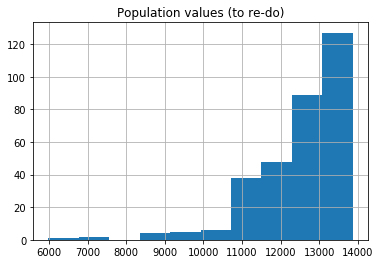

In [146]:
POIs.population.hist()
plt.title('Population values (to re-do)');

In [200]:
POIs = POIs.sample(frac=0.3)

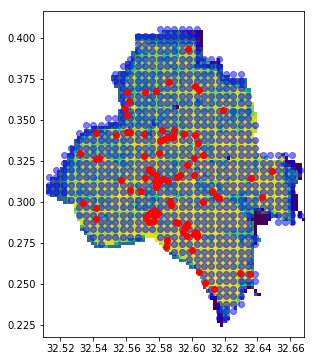

In [201]:
f,ax = plt.subplots(figsize=[6,6])
show(pop_raster, ax=ax)
ED_clipped.plot(ax = ax, color='b', alpha = 0.5)
POIs.plot(ax=ax, color='r')

## ANALYSIS
#### 6. Road network to time

In [148]:
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [149]:
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [151]:
gn.save(G, 'Kampala_G','data/')

In [153]:
nx.read_gpickle('data/Kampala_G.pickle')

In [35]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [36]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [37]:
gn.example_edge(G,1)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a3f46f278>, 'time': 7.693560000000001, 'mode': 'drive'})


#### 7. Snap firms and POIs to graph

In [202]:
grid_with_nearest_node_field = gn.pandana_snap(G, ED_clipped)
pois_with_nearest_node_field = gn.pandana_snap(G, POIs)
print("ES shape: {}, pois shape: {}".format(grid_with_nearest_node_field.shape, pois_with_nearest_node_field.shape))

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1576: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


ES shape: (723, 14), pois shape: (97, 20)


In [203]:
list_of_nearest_nodes_grid = list(grid_with_nearest_node_field.NN)
list_of_nearest_nodes_pois = list(pois_with_nearest_node_field.NN)

#### 8. Get flood raster and intersect it

In [40]:
# Data 
path = 'data'
tif = '50yrflood_Kampala.tif'
tif_path = os.path.join(path, tif)

In [41]:
G = gn.sample_raster(G, tif_path, property_name = 'flood_depth')

In [42]:
G_node_gdf = gn.node_gdf_from_graph(G)

print("Flooding is positive in {:.1f}% of nodes.".format(
    (G_node_gdf[G_node_gdf.flood_depth > 0].shape[0] / G_node_gdf.shape[0])*100))

print("Flooding exceeds 15 centimeters for {:.1f}% of nodes and exceeds 40 centimeters for {:.1f}% of nodes.".format(
    ((G_node_gdf[G_node_gdf.flood_depth > 0.15].shape[0] / G_node_gdf.shape[0]*100)),
    (G_node_gdf[G_node_gdf.flood_depth > 0.4].shape[0] / G_node_gdf.shape[0])*100))

Flooding is positive in 4.1% of nodes.
Flooding exceeds 15 centimeters for 3.0% of nodes and exceeds 40 centimeters for 0.6% of nodes.


#### 9. Calculate baseline OD matrix

In [46]:
gn.example_edge(G)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a3f46f278>, 'time': 7.693560000000001, 'mode': 'drive'})


In [48]:
def calculate_OD(G, origins, destinations, fail_value, weight = 'time'):
    #### Function for generating an origin: destination matrix  ####
    # REQUIRED: G - a graph containing one or more nodes
    #           fail_value - the value to return if the trip cannot be completed (implies some sort of disruption / disconnected nodes)
    #           origins - a list of the node IDs to treat as origins points
    #           destinations - a list of the node IDs to treat as destination points
    # OPTIONAL: weight - use edge weight of 'time' unless otherwise specified
    # RETURNS:  a numpy matrix of format OD[o][d] = shortest time possible
    # -------------------------------------------------------------------------#

    OD = np.zeros((len(origins), len(destinations)))

    for o in range(0, len(origins)):
        origin = origins[o]
        results_dict = nx.single_source_dijkstra_path_length(G, origin, cutoff = None, weight = weight)

        for d in range(0, len(destinations)):
            destination = destinations[d]
            if destination in results_dict.keys():
                OD[o][d] = results_dict[destination]
            else:
                OD[o][d] = fail_value

    return OD

#### 10. Disrupt network, calculate flooded OD matrix

In [112]:
my_flood_depth = 0.15

In [52]:
importlib.reload(gn)
G_flood = G.copy()
G_flood = gn.disrupt_network(G_flood, 'flood_depth', my_flood_depth, fail_value)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
nodes disrupted: 412
edges disrupted: 1195


In [205]:
fail_value = 999999999999999
baseline_OD = calculate_OD(G, list_of_nearest_nodes_grid, list_of_nearest_nodes_pois, fail_value)
flood_OD = calculate_OD(G_flood, list_of_nearest_nodes_grid, list_of_nearest_nodes_pois, fail_value)

In [207]:
baseline_OD_df = pd.DataFrame(baseline_OD)
flood_OD_df = pd.DataFrame(flood_OD)
flood_OD_df = flood_OD_df[flood_OD_df < fail_value]

#### 11. Calculate difference

In [181]:
minutes = 10
threshold = minutes * 60

In [214]:
threshold

600

In [208]:
percent_reachable = baseline_OD_df[baseline_OD_df < threshold].count(axis=1) / baseline_OD_df.shape[1] * 100
percent_reachable_flood = flood_OD_df[flood_OD_df < threshold].count(axis=1) / flood_OD_df.shape[1] * 100

In [217]:
baseline_OD

array([[146.,  99., 136., ..., 119., 116., 148.],
       [148., 101., 138., ..., 121., 118., 150.],
       [145.,  98., 135., ..., 118., 115., 147.],
       ...,
       [ 63., 112.,  78., ...,  83.,  96., 112.],
       [ 80.,  61.,  89., ...,  55.,  69.,  81.],
       [ 45.,  33.,  61., ...,  23.,  41.,  45.]])

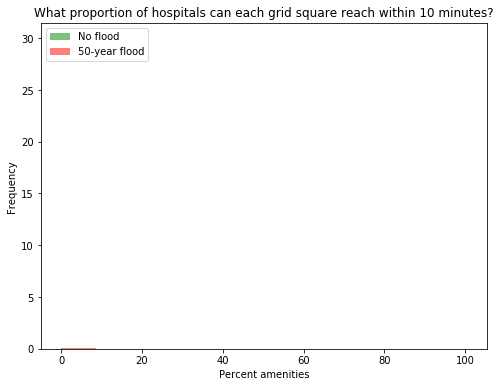

In [209]:
title = 'What proportion of hospitals can each grid square reach within {} minutes?'.format(minutes)

fig,ax = plt.subplots(figsize=[8,6])
ax.hist(percent_reachable,color='g',alpha=0.5,density=True,bins=30)
ax.hist(percent_reachable_flood,color='r',alpha=0.5,density=True,bins=30)
plt.title(title)
plt.ylabel('Frequency')
plt.legend(['No flood','50-year flood'])
plt.xlabel('Percent amenities');

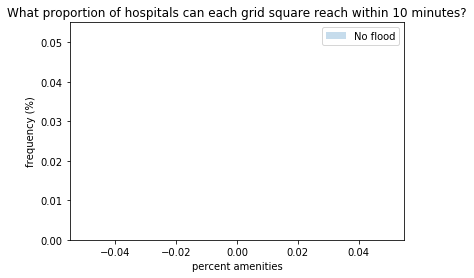

In [189]:
ax = sns.kdeplot(percent_reachable,shade=True)
#sns.kdeplot(percent_reachable_flood, ax=ax, color='r',shade=True)
ax.set_title(title)
plt.legend(['No flood','50-year flood'])
ax.set(xlabel="percent amenities", ylabel='frequency (%)');

outputs:
* re-run with other return periods
* travel time between firms, numbers and graph
* increase in travel time to closest hospital. 
* increase in travel time to nearest bank
- check out: how many firms lose access completely. extreme cases where travel time increases 100% or so. 

#### 11. Travel time to nearest hospital, before and after

In [185]:
print(baseline_OD_df.shape)
baseline_shortest_times = baseline_OD_df.min(axis=1)
flooded_shortest_times = flood_OD_df.min(axis=1)
print(baseline_shortest_times.shape)

(723, 65)
(723,)


In [186]:
flooded_shortest_times = flooded_shortest_times[flooded_shortest_times<fail_value]
flooded_shortest_times = flooded_shortest_times / 60
baseline_shortest_times = baseline_shortest_times / 60

In [187]:
gn.example_edge(G)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a3f528d30>})


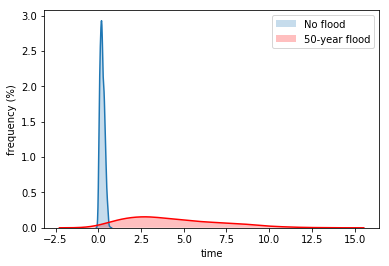

In [188]:
ax = sns.kdeplot(baseline_shortest_times,shade=True)
sns.kdeplot(flooded_shortest_times, ax=ax, color='r',shade=True)
ax.set_title('')
plt.legend(['No flood','50-year flood'])
ax.set(xlabel="time", ylabel='frequency (%)');